In [1]:
import os
import sys
root = os.path.split(os.getcwd())[0]
if root not in sys.path:
    sys.path.append(root)
!{sys.executable} -m pip install numpy pandas intervaltree matplotlib



You should consider upgrading via the '/Users/alex/dev/mellow-strategy-sdk/.venv/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
from strategy.data import RawData
from strategy.primitives import Pool, Token, Fee
pool = Pool(Token.WBTC, Token.WETH, Fee.MIDDLE)
raw = RawData.from_pool(pool)

Done


,c,c_inv,vol0,vol1,l,vol,fee
block_time,,,,,,,
2021-06-26,17.627674,0.056729,223.012116,2581.063079,39243.880583,6512.247899,195.367437
2021-06-27,17.876601,0.055939,510.589121,9432.273978,169829.323712,18559.872174,556.796165
2021-06-28,16.839203,0.059385,337.763748,12573.166426,56643.203808,18260.838684,547.825161
2021-06-29,16.400610,0.060973,394.073558,4691.754175,89876.817564,11154.801017,334.644031
2021-06-30,16.511300,0.060565,159.386285,4943.325796,178009.296934,7575.000510,227.250015


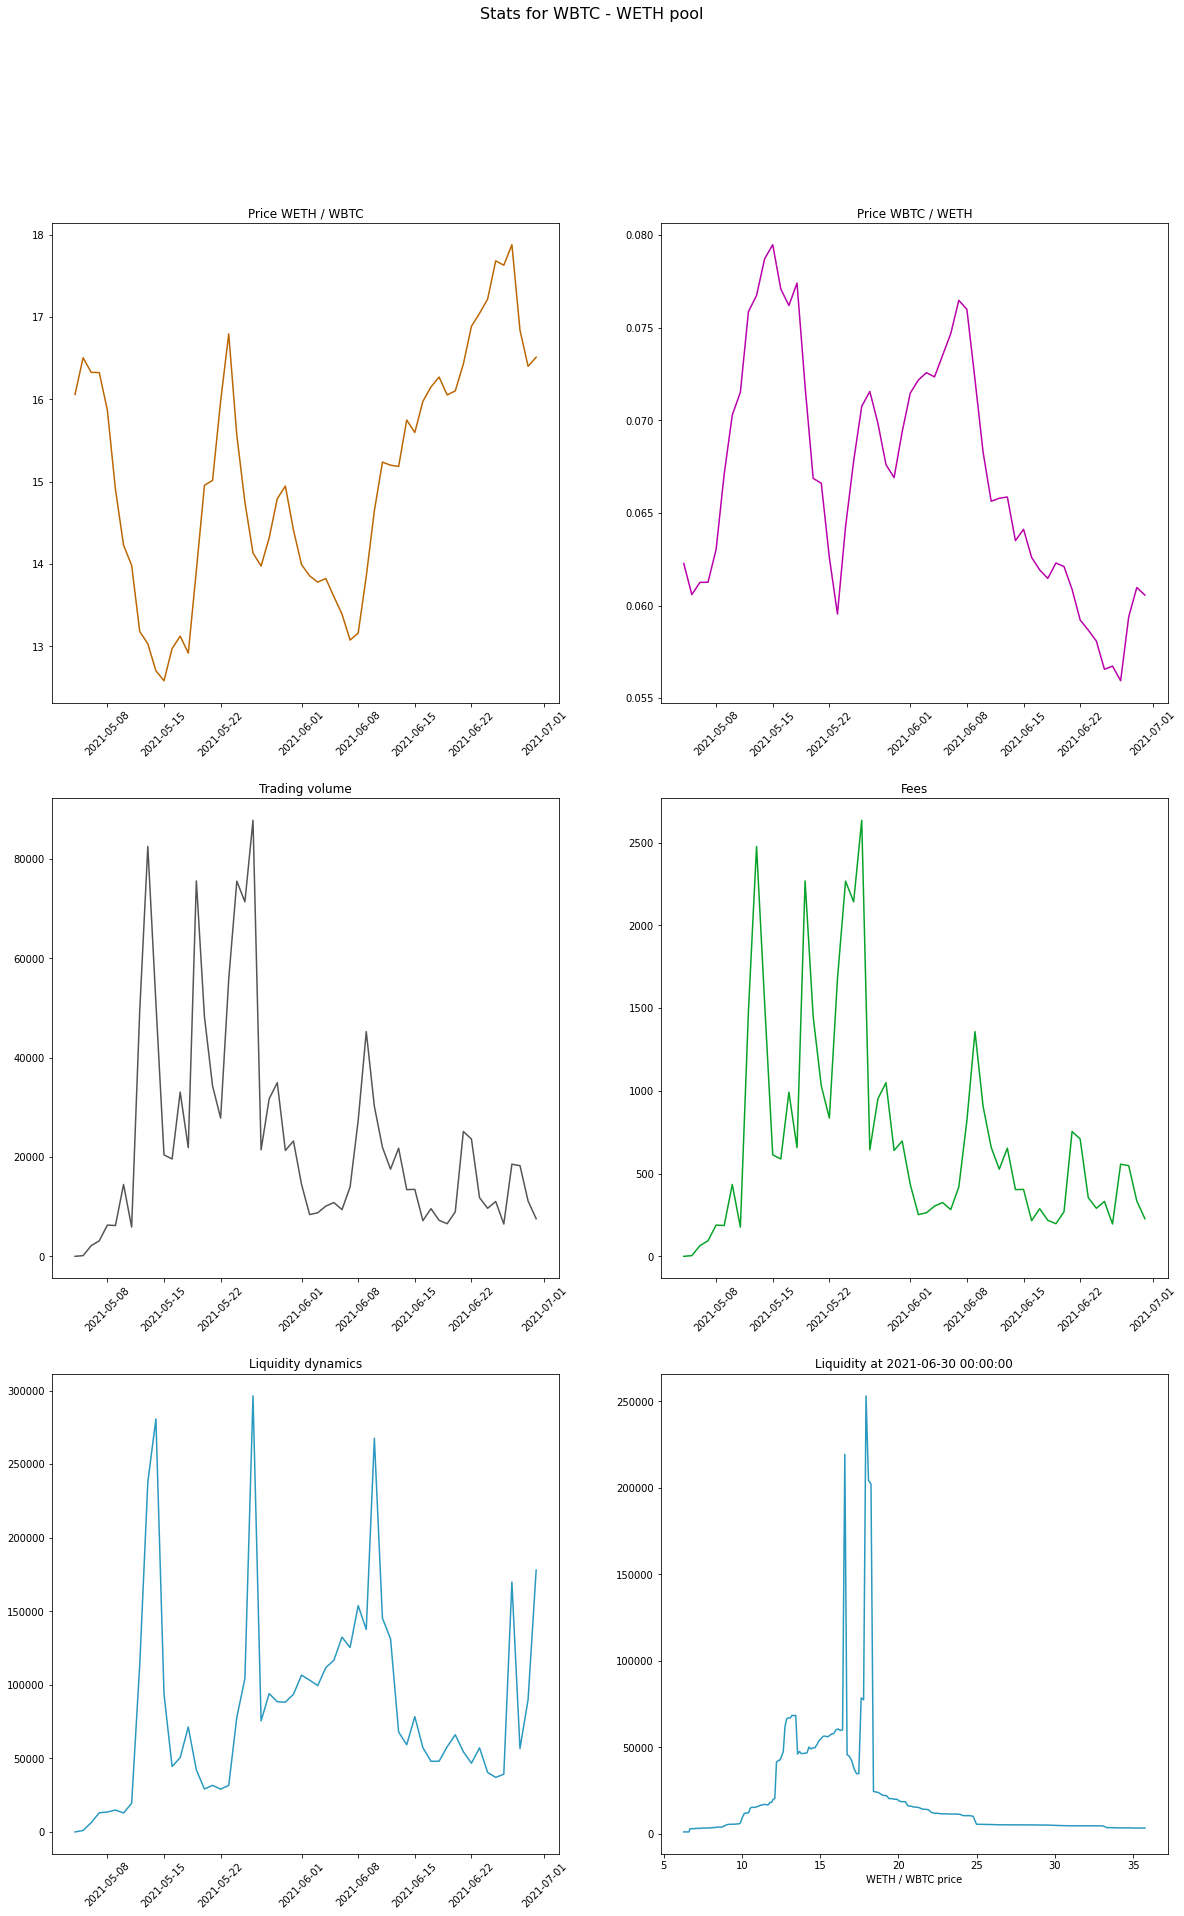

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from strategy.primitives import Pool, Frequency
from strategy.data import PoolData

p = PoolData.from_raw_data(raw, Frequency.DAY)
display(p.data.tail())
p.plot()


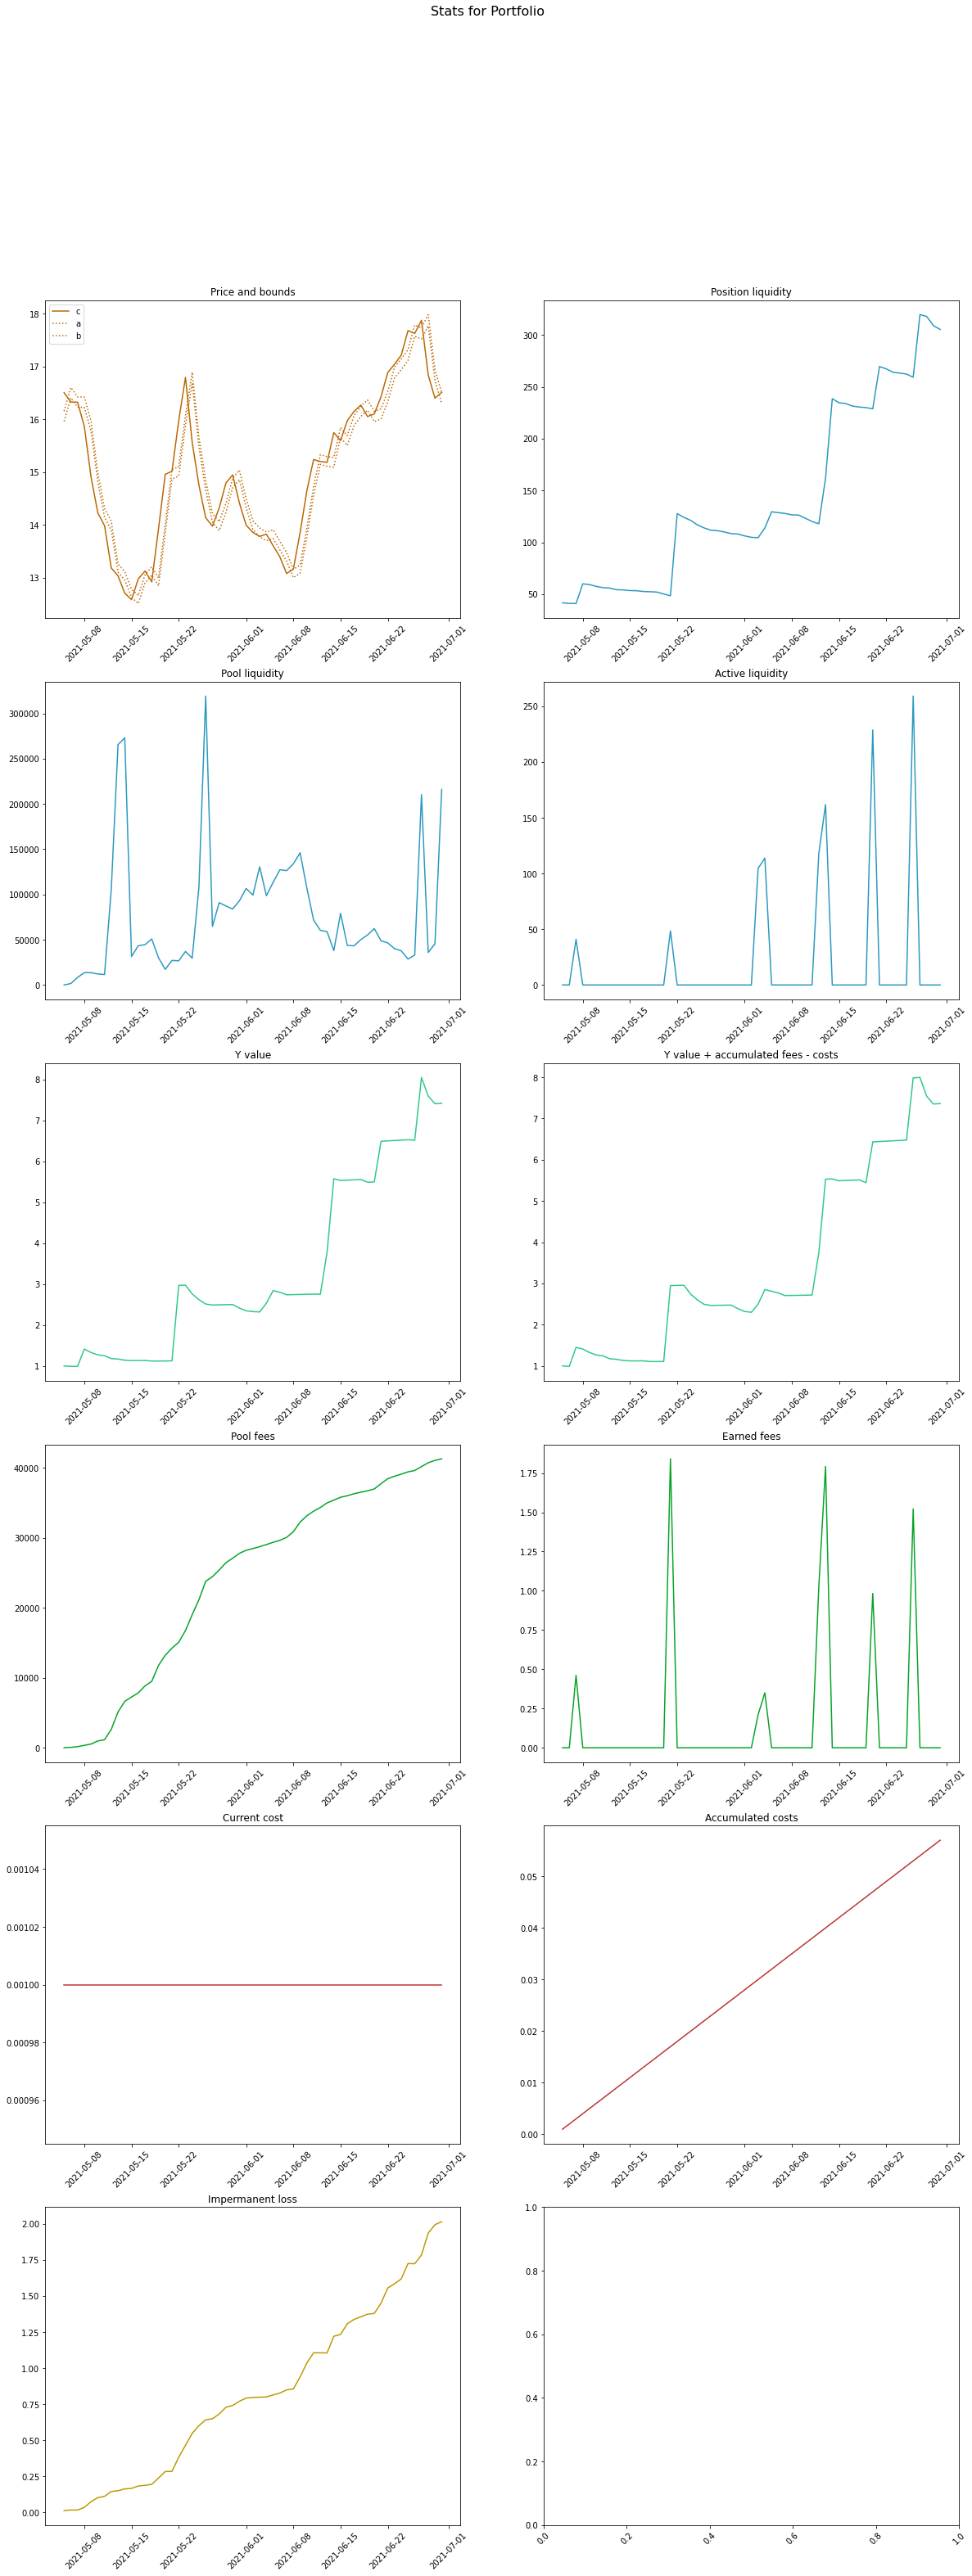

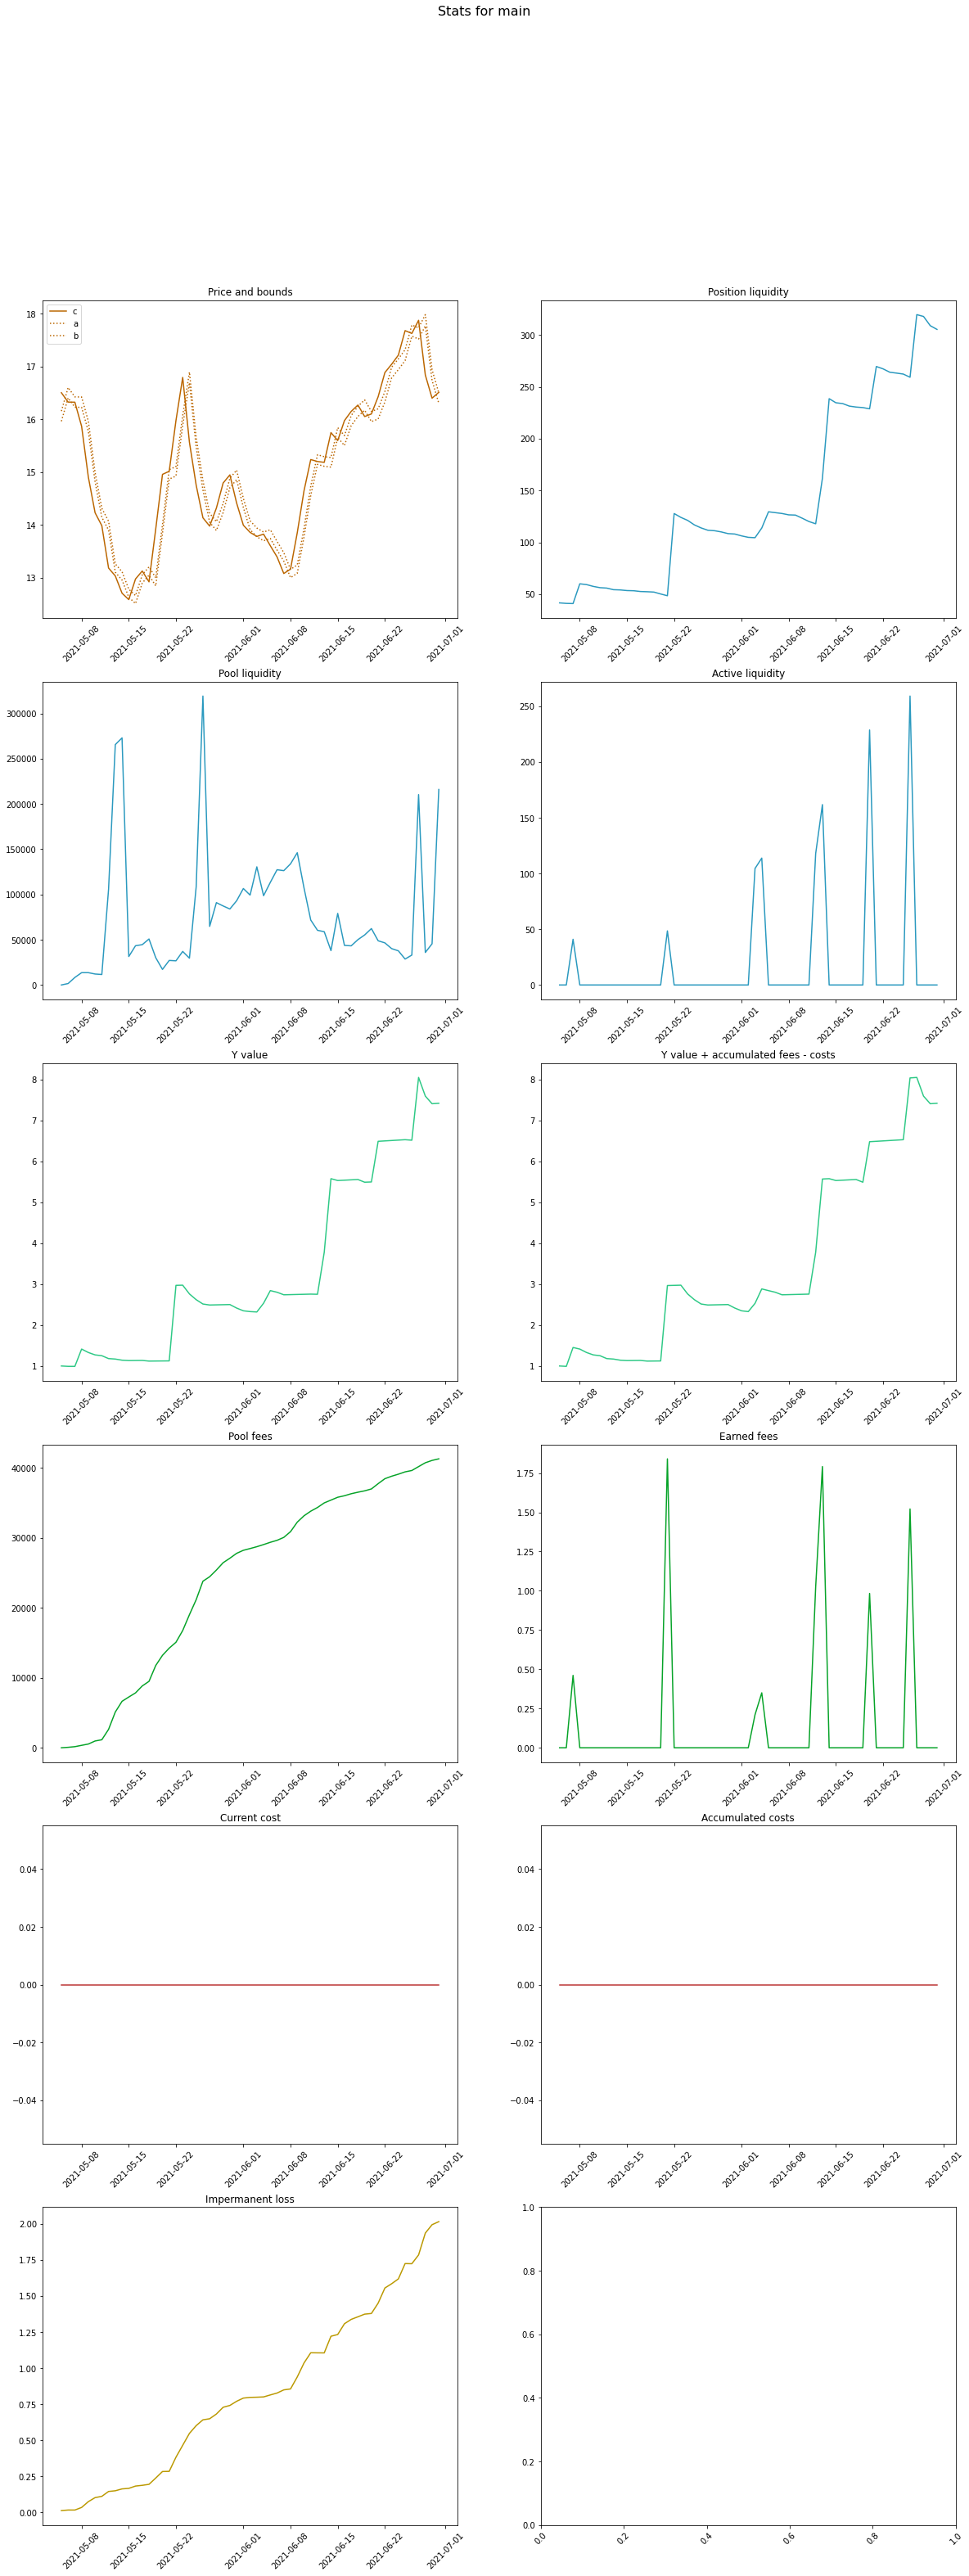

In [4]:
from strategy.portfolio import Position
from strategy.backtest import AbstractStrategy, Backtest
from strategy.data import PoolData
from datetime import datetime
from typing import Callable

class RebalanceStrategy(AbstractStrategy):        
    def rebalance(
        self,
        t: datetime,
        c: float,
        vol: float,
        l: Callable[[float], float],
        pool_data: PoolData,
    ) -> bool:
        if not self.portfolio.position("main"):
            self.portfolio.add_position(Position(id="main", a = c / 1.0001 ** 60, b = c * 1.0001 ** 60))
            pos = self.portfolio.position("main")
            pos.deposit(c, 1)
        else:
            pos = self.portfolio.position("main")
            pos.set_a(c / 1.0001 ** 60, c)
            pos.set_b(c * 1.0001 ** 60, c)

        return True
backtest = Backtest(RebalanceStrategy())
# data = p["2021-06-20":"2021-06-30"]
data = p
backtest.run(data, 0.001)
backtest.plot(20, 50)